In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

import time
from functools import wraps
from xml.etree import ElementTree

import pandas as pd
import numpy as np
from datetime import datetime, date
from pykrx import stock



In [2]:
# def my_ticker(*names):    
#     df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
#     df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)
#     df_code = df_code[['회사명', '종목코드']]
#     code_list = []
#     for name in names:
#         code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
#         code_list.append(code)
#     return code_list
# #     return code.strip()
# my_ticker('삼성전자','현대자동차')

In [3]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)

    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code_list.append(code)
    return code_list

# stocks = my_ticker(['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER'])
# print(stocks)

In [4]:
# def logger(func):
#     @wraps(func)
#     def wrapper(*args, **kwargs):
#         start = time.perf_counter()
#         success, failed = func(*args, **kwargs)
#         end = time.perf_counter() - start
#         func_start, func_end = args[0], args[1]
#         print(#f'#date: {func_start} ~ {func_end}, \n',
#               f'#success: {success} item(s), \n',
#               f'#failed: {failed} item(s), \n',
#              )
#     return wrapper
# @logger
def my_krx(start, end, *codes):
    error_list = []
    failed = 0
    success = 0
    for code in codes:
        try:
            df = stock.get_market_ohlcv_by_date(start, end, code)
            df.reset_index(inplace=True)
            df.insert(loc=1, column='종목코드', value=code)
            df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
            success += 1
        except ElementTree.ParseError as e:
            error_list.append(e)
            drop_rows(database, table, code)  # 특정 종목코드에서 에러 발생 시 해당 종목코드에 대한 데이터 삭제 후 다음 종목코드로 넘어감
            failed += 1
            continue
        except Exception as e:
            print('Error occurred : ', e)
            failed += 1
            continue
    print(f'success:{success}, failed:{failed}')
    return df

In [5]:
stocks = ['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER']
stock_code = my_ticker(stocks)
print(stock_code)

df = pd.DataFrame()
for i, code in enumerate(stock_code):
    col = stocks[i]
    df[col]= my_krx('20160104', '20180427', code)['close']
df.head()

['005930', '000660', '005380', '035420']
success:1, failed:0
success:1, failed:0
success:1, failed:0
success:1, failed:0


,삼성전자,SK하이닉스,현대자동차,NAVER
0,24100,30150,144000,126579
1,24160,30600,143500,127580
2,23500,30750,140000,124776
3,23260,30200,137500,130585
4,23420,29700,136500,130585


In [6]:
 
daily_ret = df.pct_change() 
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov() 
annual_cov = daily_cov * 252

port_ret = [] 
port_risk = [] 
port_weights = [] 

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_ret) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 

portfolio = {'Returns': port_ret, 'Risk': port_risk} 
for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk'] + [s for s in stocks]] 
df

,Returns,Risk,삼성전자,SK하이닉스,현대자동차,NAVER
0,0.212604,0.181361,0.209552,0.136813,0.255188,0.398447
1,0.343733,0.224956,0.771567,0.059622,0.015681,0.153131
2,0.241071,0.179879,0.141388,0.253114,0.360791,0.244707
3,0.291814,0.184793,0.350236,0.224179,0.164491,0.261094
4,0.290981,0.184390,0.280187,0.270111,0.197803,0.251900
...,...,...,...,...,...,...
19995,0.277264,0.185164,0.239383,0.264718,0.188821,0.307079
19996,0.334963,0.194802,0.340124,0.333485,0.209066,0.117325
19997,0.317215,0.194560,0.204727,0.383196,0.241871,0.170205
19998,0.253800,0.207238,0.034179,0.362328,0.548043,0.055450


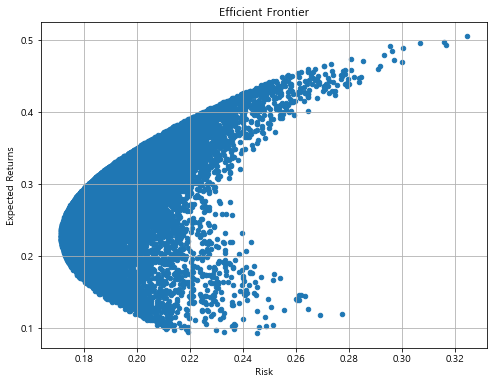

In [7]:
df.plot.scatter(x='Risk', y='Returns', figsize=(8, 6), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 